# Datatools

> This module defines handler functions for loading phase response data, or creating simulated datasets for testing the algorithms

In [12]:
#| default_exp datatools

In [13]:
#| hide
from nbdev.showdoc import *

In [14]:
#| export
#| hide


import torch
import pylab as plt
from torch.utils.data import DataLoader, Dataset
import torchcde
import numpy as np
from torchdiffeq import odeint as odeint
from typing import List, Tuple, Union
import pandas as pd 



In [15]:
#| export

class ForcingFunction:
    
    def __init__(self, start: float = 0.0, stop: float = 48.0, nsamples: int = 1000):
        self.start = start
        self.stop = stop
        
        self.kinks = []

        self.ts = torch.linspace(start, stop, 1000)
        self.vals = torch.zeros_like(self.ts)

    def add_pulse(self, t1, t2, amplitude, steep: float = 1.0): # was 10.0
        def p(t): return amplitude * \
            (0.5*torch.tanh(steep*(t-t1))-0.5*torch.tanh(steep*(t-t2)))
        self.vals += p(self.ts)
        self.kinks += [t1, t2]
        
    def tstart(self, threshold = 0.10):
        for time,val in zip(self.ts, self.vals):
            if val > threshold:
                return time
        return np.inf 

    def random_pulse(self, amplitude_range: Tuple, duration_range: Tuple = None):
        A = amplitude_range[0] + (amplitude_range[1] -
                                  amplitude_range[0])*np.random.rand()
        dur = duration_range[0] + (duration_range[1] -
                                   duration_range[0])*np.random.rand()
        t1 = self.start + (self.stop-self.start)*np.random.rand()
        t2 = min(t1+dur, self.stop)
        self.add_pulse(t1, t2, A)

    def to_spline_coeff(self):
        x_interp = torch.linspace(self.start, self.stop, 1000)
        y_interp = torch.tensor([self.__call__(x_interp[k])
                                for k in range(len(x_interp))])
        Xmat = torch.column_stack([x_interp, y_interp])
        coeffs = torchcde.natural_cubic_coeffs(Xmat, t=x_interp)
        return coeffs, x_interp
    
    def to_spline_cde(self):
        x_interp = torch.linspace(self.start, self.stop, 1000)
        y_interp = torch.tensor([self.__call__(x_interp[k])
                                for k in range(len(x_interp))])
        Xmat = torch.column_stack([x_interp, y_interp])
        coeffs = torchcde.natural_cubic_coeffs(Xmat)
        return coeffs, x_interp

    def __call__(self, t: float or torch.Tensor):
        return np.interp(t, self.ts.numpy(), self.vals.numpy())

    def plot(self):
        plt.plot(self.ts.numpy(), self.vals.numpy())
        plt.show()



In [16]:
#| export 

def construct_prc_pulses(amplitude, 
                         duration: float,  
                         period: float,
                         samples: int = 10,
                         num_periods: int = 2):
    pulse_indx = torch.linspace(0.0, period, samples)
    Pulses = []
    for k in range(samples):
        L1 = ForcingFunction(0.0, num_periods*period)
        L1.add_pulse(pulse_indx[k], min(pulse_indx[k]+duration, num_periods*period), amplitude)
        Pulses.append(L1)
    return(Pulses)




In [17]:
#| export

class SimPRCData(Dataset):
    
    def __init__(self,
                 model, 
                 perturbations: List[ForcingFunction], 
                 ics: List or torch.Tensor, 
                 cde: bool = False):
        """
            Oscillator model is the rhs and phase function
            for a limit cycle model. 
            Inputs is a list of functions which should
            be applied to the system in this data set
        """
        self.forcing_funcs = perturbations

        # If one ics is given just repeat that

        ics = [ics for _ in range(len(perturbations))]
        self.phases = []
        self.t_data = []
        self.initial_cond = []
        self.coeffs = []
        self.time_coeffs = []

        for f, u0 in zip(self.forcing_funcs, ics):
            model.set_pulse(f)
            ts = torch.tensor([f.start, f.stop]) # just start and finish
            trajectory = odeint(model, u0, ts).detach().cpu()
            self.phases.append(model.to_phase(trajectory))
            self.t_data.append(ts)
            self.initial_cond.append(u0)
            if cde:
                sc, ts_coeff = f.to_spline_cde()
                self.coeffs.append(sc)
                self.time_coeffs.append(ts_coeff)
            else:
                sc, ts_coeff = f.to_spline_coeff()
                self.coeffs.append(sc)
                self.time_coeffs.append(ts_coeff) #save the start and stop times 
            

    def __getitem__(self, k):
        """
            Return a single data point
            y0, t, coeff, phases
        """
        return self.initial_cond[k], self.t_data[k], self.phases[k], self.coeffs[k], self.time_coeffs[k]

    def __len__(self):
        return len(self.forcing_funcs)

    def plot(self, ax=None):
        if not ax:
            plt.figure()
            ax = plt.gca()
        for (j, p) in enumerate(self.phases):
            ax.plot(self.t_data[j], torch.sin(p),
                    color='darkgreen', alpha=0.20, label='data')


In [18]:
#| export

def find_prc_exp(model, pulses, ics):

    fzero = ForcingFunction(pulses[0].start, pulses[0].stop)
    model.set_pulse(fzero)
    ts = torch.linspace(fzero.start, fzero.stop, 1000)
    trajectory = odeint(model, ics, ts).detach().cpu()
    zero_phase = trajectory[-1, 1]

    phase_shifts = []

    for f in pulses:
        model.set_pulse(f)
        ts = torch.linspace(f.start, f.stop, 100)
        trajectory = odeint(model, ics, ts).detach().cpu()
        phase = trajectory[-1, 1]
        phase_shifts.append(phase-zero_phase)

    return phase_shifts




In [19]:
#| export

class PRCData(Dataset):
    
    def __init__(self, perturbations: List[ForcingFunction], phase_shifts: List[float], ics: List[float]):
        self.forcing_funcs = perturbations
        self.phases = [ torch.tensor([ics[1],phase_shifts[k]]) for k in range(len(phase_shifts)) ]
        self.t_data = []
        self.initial_cond = []
        self.coeffs = []
        self.time_coeffs = []
        self.simple_phases = phase_shifts
        
        for f in perturbations:
            ts = torch.tensor([f.start, f.stop]) 
            self.t_data.append(ts)
            self.initial_cond.append(torch.tensor(ics))
            sc, ts_coeff = f.to_spline_coeff()
            self.coeffs.append(sc)
            self.time_coeffs.append(ts_coeff)

    def __getitem__(self, k):
        """
            Return a single data point
            y0, t, coeff, phases
        """
        return self.initial_cond[k], self.t_data[k], self.phases[k], self.coeffs[k], self.time_coeffs[k]

    def __len__(self):
        return len(self.forcing_funcs)

    def plot(self, ax=None):
        if not ax:
            plt.figure()
            ax = plt.gca()
        pulseTiming = [ f.tstart() for f in self.forcing_funcs ]
        ax.scatter(pulseTiming, self.phases, color='darkgreen', label='data')
        plt.show()


In [20]:

#| export 

def loadComas(durations: List[int] = [1,3,4,6,9,12,18]):
    shifts = [] 
    pulses = [] 

    for duration in durations:
        filename = "./data/Comas2006" + str(duration) + "Hr.csv"
        df = pd.read_csv(filename)
        df = df[df['x'] < 25.0]
        pulseTimings = list(map(lambda x: np.fmod(x, 24.0), df['x'].to_list() ))
        shifts += list(map(lambda x: x * torch.pi/12.0, df['Curve1'].to_list()))
        
        for timing in pulseTimings:
            pulse = ForcingFunction(start=0.0, stop=96.0)
            pulse.add_pulse(timing + 24.0 - duration/2.0, timing + 24.0 + duration /2.0, 100.0 / 1000.0)
            pulses.append(pulse) 
        
    return PRCData(pulses, shifts, [0.70,0.0])
        
    




## Models

In [21]:
#| export
#| hide

import torch
import torch.nn as nn
from torch.nn.modules import linear
import torch.optim as optim
import pytorch_lightning as pl
import pylab as plt
from torch.utils.data import DataLoader, Dataset
import torchcde
import numpy as np
from torchdiffeq import odeint as odeint
from typing import List, Tuple, Union
from scipy.signal import argrelextrema


In [47]:
#| export 

def find_prc(model: nn.Module,
             pulses: List[ForcingFunction],
             ics: torch.Tensor,
             exp=None) -> np.ndarray :
    
    final_phases = []
    
    fzero = ForcingFunction(pulses[0].start, pulses[0].stop)
    coeffs, ts_coeffs = fzero.to_spline_coeff()
    model.update_coeff(coeffs, ts_coeffs)
    u0 = ics  
    ts = torch.linspace(fzero.start, fzero.stop, 3000)
    trajectory = odeint(model, u0, ts, rtol=1e-9,
                        atol=1e-9, method='rk4').detach().cpu()
    zero_phase = model.to_phase(trajectory)[-1]

    for f in pulses:
        coeffs, ts_coeffs = f.to_spline_coeff()
        model.update_coeff(coeffs, ts_coeffs)
        u0 = ics  
        ts = torch.linspace(f.start, f.stop, 100)
        trajectory = odeint(model, u0, ts, rtol=1e-9,
                            atol=1e-9, method='rk4').detach().cpu()
        final_phase_perturbed = model.to_phase(trajectory)[-1]
        final_phases.append( final_phase_perturbed - zero_phase)

    return np.array(final_phases)

In [22]:
#| export 

class PolarModel(nn.Module):

    def __init__(self,
                 tau: float = 24.0,
                 K: float = 0.30,
                 beta: float = 0.02,
                 gamma: float = 0.1,
                 A = [1.0, 0.4],
                 B = [0.0, 0.3],):
        super().__init__()
        self.omega = torch.tensor(2.0*torch.pi/tau)
        self.K = torch.tensor(K)
        self.gamma = torch.tensor(gamma)
        self.beta = torch.tensor(beta)
        self.pulse = lambda t: 0.0
        self.A = torch.tensor(A)
        self.B = torch.tensor(B)
        self.sigma = 0.0

    def set_pulse(self, f):
        self.pulse = f

    def forward(self, t, state):
        R = state[0]
        psi = state[1]

        pulseAmp = self.A[0]*0.5*(1.0-R**4.0)*torch.cos(
            psi+self.B[0])+self.A[1]*0.5*R*(1.0-R**8.0)*torch.cos(2.0*psi+self.B[1])
        pulsePhase = self.sigma-self.A[0]*0.5*(R**3+1.0/R)*torch.sin(
            psi+self.B[0])-self.A[1]*0.5*(1.0+R**8)*torch.sin(2.0*psi+self.B[1])

        dR = - self.gamma*R+self.K * \
            torch.cos(self.beta)/2.0*R*(1-R**2) + self.pulse(t)*pulseAmp
        dPsi = self.omega + self.K * \
            torch.sin(self.beta)/2.0*(1+R**2) + self.pulse(t)*pulsePhase
        dfunc = torch.hstack((dR, dPsi)).view(state.shape)
        return dfunc

    def to_phase(self, trajectory):
        return trajectory[:, 1]


In [23]:
#| export 

class HopfOscillator(nn.Module):
    
    def __init__(self,
                 mu: float = 1.0,
                 tau: float = 24.0,
                 epsilon: float = 0.5
                 ):
        super().__init__()
        self.omega = torch.tensor(2.0*torch.pi/tau)
        self.mu = torch.tensor(mu)
        self.epsilon = torch.tensor(epsilon)

    def update_coeff(self, coeffs, time_coeffs):
        self.forcing = torchcde.CubicSpline(coeffs, t=time_coeffs)
        
    def set_pulse(self, f):
        self.pulse = f

    def forward(self, t, state):
        X = state[0]
        Y = state[1]
        
        dX = (self.mu - X**2 - Y**2)*X - self.omega*Y + self.epsilon*self.pulse(t)
        dY = (self.mu - X**2 - Y**2)*Y + self.omega*X + self.epsilon*self.pulse(t)
        dfunc = torch.hstack((dX, dY)).view(state.shape)
        return dfunc

    def to_phase(self, trajectory) -> torch.Tensor:
        return torch.atan2(trajectory[:, 1], trajectory[:, 0])
    
    def to_polar(self, trajectory):
        return torch.stack((torch.sqrt(trajectory[:, 0]**2+trajectory[:, 1]**2), 
                            torch.atan2(trajectory[:, 1], trajectory[:, 0])), 
                           dim=1)
    
    


In [24]:
#| export 

class KuramotoNetworkModel(nn.Module):
    
    def __init__(self,
                 tau: float = 24.0,
                 K: float = 0.30,
                 beta: float = 0.02,
                 gamma: float = 0.1):
        super().__init__()
        self.omega = torch.tensor(2.0*torch.pi/tau)
        self.K = torch.tensor(K)
        self.gamma = torch.tensor(gamma)
        self.beta = torch.tensor(beta)
        self.pulse = lambda t: 0.0
        self.A = torch.tensor([1.0,0.4])
        self.B = torch.tensor([0.0,0.3])
        self.sigma = 0.0

    def set_pulse(self, f):
        self.pulse = f

    def forward(self, t, state):
        R = state[0]
        psi = state[1]
        
        pulseAmp = self.A[0]*0.5*(1.0-R**4.0)*torch.cos(
            psi+self.B[0])+self.A[1]*0.5*R*(1.0-R**8.0)*torch.cos(2.0*psi+self.B[1])
        pulsePhase = self.sigma-self.A[0]*0.5*(R**3+1.0/R)*torch.sin(
            psi+self.B[0])-self.A[1]*0.5*(1.0+R**8)*torch.sin(2.0*psi+self.B[1])
        
        
        dR = - self.gamma*R+self.K*torch.cos(self.beta)/2.0*R*(1-R**2) + self.pulse(t)*pulseAmp
        dPsi = self.omega + self.K * \
            torch.sin(self.beta)/2.0*(1+R**2) + self.pulse(t)*pulsePhase
        dfunc = torch.hstack((dR, dPsi)).view(state.shape)
        return dfunc

    def to_phase(self, trajectory):
        return trajectory[:, 1]
    


In [56]:
#| export 

class VDP(nn.Module):

    def __init__(self,
                 tau: float = 24.0,
                 K: float = 0.30,
                 beta: float = 0.02,
                 gamma: float = 0.1):
        super().__init__()
        self.mu = 0.23
        self.kparam = 0.55
        self.tau = 24.2 
        
    def update_coeff(self, coeffs, time_coeffs):
        self.forcing = torchcde.CubicSpline(coeffs, t=time_coeffs)

    def forward(self, t, state):
        x = state[0]
        xc = state[1]
        Bhat  = self.forcing.evaluate(t)[1]
        dx  = torch.pi/12.0*(xc+Bhat)
        dxc = torch.pi/12.0*(self.mu*(xc-4.0/3.0*xc**3.0)-x*((24.0/(0.99669*self.tau))**2.0+self.kparam*Bhat))
        dfunc = torch.hstack((dx, dxc)).view(state.shape)
        return dfunc
    
    def to_phase(self, trajectory):
        return torch.atan2(trajectory[:, 1], trajectory[:, 0])
        
    def prc_point(self, pulse, ics):
        fzero = ForcingFunction(pulse.start, pulse.stop)
        self.set_pulse(fzero)
        ts = torch.linspace(fzero.start, fzero.stop, 100)
        trajectoryNull = odeint(self.forward, ics, ts).detach().cpu()
        self.set_pulse(pulse)
        trajectory = odeint(self.forward, ics, ts).detach().cpu()
        #plt.plot(trajectoryNull[:,0], trajectoryNull[:,1], ls='--')
        #plt.plot(trajectory[:,0], trajectory[:,1])
        #plt.show()
        phase_null = VDP.to_phase(ts, trajectoryNull)
        phase_pulse =  VDP.to_phase(ts, trajectory)
        
        return phase_pulse[-1] - phase_null[-1]
        
    




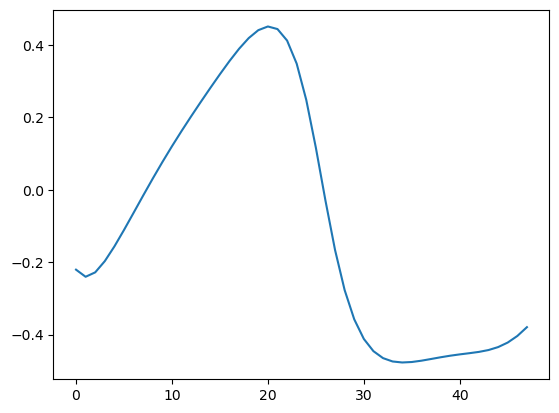

In [57]:
model = VDP() 
pulses = construct_prc_pulses(2.0, 1.0, 24.0, samples=48) 

prc = find_prc(model, pulses=pulses, ics=torch.tensor([1.0,1.0]))


# prc = []
# for p in pulses:
#     prc.append(model.prc_point(p, torch.tensor([1.0,1.0])))
    
plt.plot(prc)
plt.show()

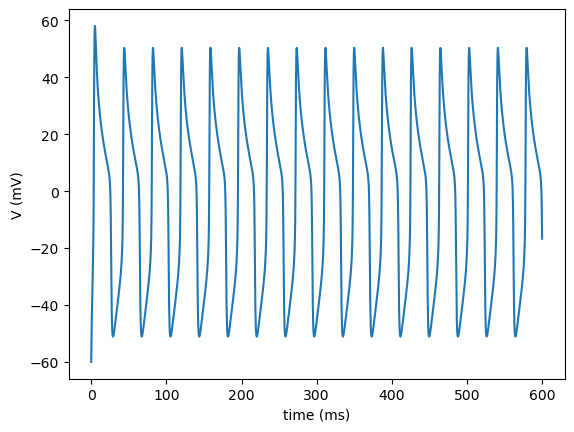

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def morris_lecar_model(t, y, V1, V2, V3, V4, phi):
    V, n = y
    dVdt = (1/C) * (I - g_Ca * m_inf(V) * (V - V_Ca) - g_K * n * (V - V_K) - g_L * (V - V_L))
    dndt = phi * (n_inf(V) - n) / tau_n(V)
    return [dVdt, dndt]

def m_inf(V):
    return 0.5 * (1 + np.tanh((V - V1) / V2))

def n_inf(V):
    return 0.5 * (1 + np.tanh((V - V3) / V4))

def tau_n(V):
    return 1 / (np.cosh((V - V3) / (2 * V4)))

C = 1
g_Ca = 1.1
V_Ca = 120
g_K = 2.0
V_K = -84
g_L = 0.5
V_L = -60
V1 = -1.2
V2 = 18
V3 = 12
V4 = 17.4
phi = 0.039
I = 25.0

t_span = [0, 600]
y0 = [-60, 0.05]

sol = solve_ivp(lambda t, y: morris_lecar_model(t, y, V1, V2, V3, V4, phi), t_span, y0, t_eval=np.linspace(0,600,3000))

plt.plot(sol.t, sol.y[0])
plt.xlabel('time (ms)')
plt.ylabel('V (mV)')
plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()